In [1]:
import cffi
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio import Entrez
import time
import argparse
import sys
from src.SequenceProcessor import SequenceProcessor
from src.FileHandler import FileHandler
from src.pytrsomix import SeqAnalyzer,TRScalculator
from src.stats import Stats
from src.BlastProcessor import BLASTProcessor
import pathlib

In [79]:
#CREATE NEW CLUSTERS

cdhit_clusters_file = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/cd-hit-results/combined_sequences_unique_cdhit.clstr"
input_fasta = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/TRS_output/combined_sequences_unique.fasta"
output_folder_cluster = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/cd-hit-results/fasta_clusters"
results_directory = '/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8/'
#FileHandler.create_fasta_for_all_clusters(cdhit_clusters_file, input_fasta, output_folder_cluster, create_individual_files=True)
test = create_trs_class_dataframe(output_folder_cluster)
test

,Cluster Size 1,Cluster Size 2,Cluster Size 3,Cluster Size 4,Cluster Size 5,Cluster Size 6,Cluster Size 7,Cluster Size 8,Cluster Size 9,Cluster Size 10,...,Cluster Size 13,Cluster Size 14,Cluster Size 15,Cluster Size 16,Cluster Size 18,Cluster Size 30,Cluster Size 38,Cluster Size 45,Cluster Size 46,Cluster Size 96
TRS Class,,,,,,,,,,,,,,,,,,,,,
L1,111,115,154,171,276,251,515,0,2,3,...,0,2,0,0,0,0,0,0,0,0
L2,132,149,143,202,294,408,684,0,0,0,...,4,0,0,0,0,0,0,0,0,52
L3,98,122,124,158,183,270,449,0,0,0,...,1,0,0,0,0,0,0,0,0,2
L4,118,140,118,158,249,326,569,0,4,0,...,0,5,0,0,0,0,0,0,0,0
L5,110,128,135,152,202,306,343,0,8,0,...,1,0,11,3,0,14,0,0,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R56,27,14,11,6,8,14,27,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R57,44,24,12,17,8,24,57,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R58,26,9,10,2,3,1,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#GENERTATE ADDITIONAL PLOTS
results_directory = "/home/hubert/TRS-omix_new/python/klebsiella_results_L100_R100_c0.8"
fasta_files_for_plotting = FileHandler.search_for_files(results_directory,'*.fasta')
fasta_files_for_plotting_names = FileHandler.extract_file_names(fasta_files_for_plotting)
print(f"Following fasta files were found in {results_directory} : {fasta_files_for_plotting_names}")
statistics = Stats()
for fasta_path in fasta_files_for_plotting:
    statistics.count_L_R(fasta_path)
file_paths = [file_path for file_path in fasta_files_for_plotting if file_path in statistics.file_info]
names_to_filter = ["full_sequences_final.fasta"]
file_paths = [file_path for file_path in file_paths if os.path.basename(file_path) in names_to_filter]
print(f"{file_paths}")
# Dictionary to store titles for each file path
file_titles = {}

# Populate file_titles dictionary using file_paths list
for file_path in file_paths:
# Extract file name from file path
    file_name = os.path.basename(file_path)

# Construct default title based on file name
default_title = f"Title for {file_name}"

# Add entry to file_titles dictionary
file_titles[file_path] = default_title

statistics.plot_lr_counts(file_paths=file_paths,file_titles=file_titles,results_directory=results_directory)

In [78]:

def create_trs_class_dataframe(cluster_folder):
    """
    Generates a DataFrame with TRS class counts across cluster sizes.

    Parameters:
        cluster_folder (str): Path to the folder containing `cluster_size_*.fasta` files.

    Returns:
        pd.DataFrame: A DataFrame with cluster sizes as columns and TRS classes as rows.
    """
    import pandas as pd
    import glob

    # Dictionary to store TRS counts for each cluster size
    trs_class_counts = {}

    # Get all `cluster_size_*.fasta` files
    fasta_files = glob.glob(os.path.join(cluster_folder, "cluster_size_*.fasta"))

    for fasta_file in fasta_files:
        # Extract cluster size from file name
        cluster_size = int(os.path.basename(fasta_file).split("_")[2].split(".")[0])

        # Initialize cluster size entry if not present
        if cluster_size not in trs_class_counts:
            trs_class_counts[cluster_size] = {}

        # Process the FASTA file
        with open(fasta_file, "r") as f:
            for line in f:
                if line.startswith(">"):  # Sequence header
                    seq_name = line.strip()[1:]  # Remove '>'
                    trs_class = seq_name.split("_")[-2]  # Extract only the TRS class prefix
                    trs_class_counts[cluster_size][trs_class] = trs_class_counts[cluster_size].get(trs_class, 0) + 1

    # Build the DataFrame from the dictionary
    # Extract all unique TRS classes
    trs_classes = set()
    for class_counts in trs_class_counts.values():
        trs_classes.update(class_counts.keys())

    # Custom sorting for TRS classes (e.g., L1, L2, ..., L60, R1, R2, ..., R60)
    def natural_sort_key(trs_class):
        prefix, number = trs_class[0], int(trs_class[1:])
        return prefix, number

    sorted_trs_classes = sorted(trs_classes, key=natural_sort_key)

    # Create a DataFrame
    df = pd.DataFrame(columns=sorted(trs_class_counts.keys()), index=sorted_trs_classes).fillna(0)

    # Populate the DataFrame
    for cluster_size, class_counts in trs_class_counts.items():
        for trs_class, count in class_counts.items():
            df.at[trs_class, cluster_size] = count

    # Rename columns for better readability
    df.columns = [f"Cluster Size {size}" for size in df.columns]
    df.index.name = "TRS Class"
    return df


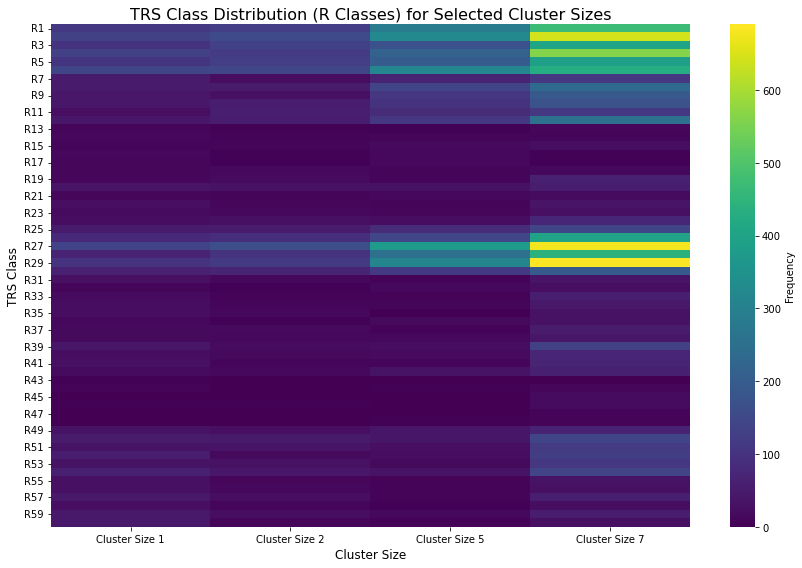

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_filtered_trs_heatmap(df, cluster_sizes, class_type='R'):
    """
    Plots a heatmap of TRS class counts for specific cluster sizes, separated by class type (R or L).

    Parameters:
        df (pd.DataFrame): DataFrame with TRS classes as rows and cluster sizes as columns.
        cluster_sizes (list): List of cluster sizes to include in the heatmap.
        class_type (str): 'R' for R classes, 'L' for L classes.
    """
    # Filter rows by class type
    filtered_rows = df[df.index.str.startswith(class_type)]

    # Filter columns by specified cluster sizes
    filtered_columns = [f"Cluster Size {size}" for size in cluster_sizes if f"Cluster Size {size}" in df.columns]
    if not filtered_columns:
        print("No matching cluster sizes found in DataFrame.")
        return

    filtered_df = filtered_rows[filtered_columns]

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(filtered_df, annot=False, cmap="viridis", cbar_kws={'label': 'Frequency'})
    plt.title(f"TRS Class Distribution ({class_type} Classes) for Selected Cluster Sizes", fontsize=16)
    plt.xlabel("Cluster Size", fontsize=12)
    plt.ylabel("TRS Class", fontsize=12)
    plt.tight_layout()
    plt.show()

# Example Usage
plot_filtered_trs_heatmap(test, cluster_sizes=[1, 2, 5, 7], class_type='R')
#plot_filtered_trs_heatmap(test, cluster_sizes=[1, 2, 5], class_type='L')



In [ ]:
def plot_trs_bar(df, trs_classes=None, class_type='R', figsize=(16, 10), bar_width=0.8):
    """
    Plots a bar chart for selected TRS classes across cluster sizes, separated by class type (R or L),
    with adjustments for better spacing.

    Parameters:
        df (pd.DataFrame): DataFrame with TRS classes as rows and cluster sizes as columns.
        trs_classes (list): List of TRS classes to visualize. If None, shows all of the specified type.
        class_type (str): 'R' for R classes, 'L' for L classes.
        figsize (tuple): Size of the plot figure.
        bar_width (float): Width of the bars in the plot.
    """
    # Filter rows by class type
    filtered_df = df[df.index.str.startswith(class_type)]

    # Select specific TRS classes if provided
    if trs_classes:
        filtered_df = filtered_df.loc[trs_classes]

    # Transpose for better orientation
    filtered_df = filtered_df.transpose()

    # Plot the bar chart
    ax = filtered_df.plot(
        kind="bar",
        figsize=figsize,
        width=bar_width,
        legend=True
    )

    # Adjust labels and title
    plt.title(f"TRS Class Counts ({class_type} Classes)", fontsize=16)
    plt.xlabel("Cluster Size", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title="TRS Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Example Usage
plot_trs_bar(test, class_type='R')
plot_trs_bar(test, class_type='L')


In [ ]:
def plot_trs_stacked_bar(df, class_type='R'):
    """
    Plots a stacked bar chart of TRS class counts by cluster size, separated by class type (R or L).

    Parameters:
        df (pd.DataFrame): DataFrame with TRS classes as rows and cluster sizes as columns.
        class_type (str): 'R' for R classes, 'L' for L classes.
    """
    # Filter rows by class type
    filtered_df = df[df.index.str.startswith(class_type)]

    filtered_df.transpose().plot(kind="bar", stacked=True, figsize=(14, 8), cmap="tab20")
    plt.title(f"Stacked TRS Class Counts ({class_type} Classes)", fontsize=16)
    plt.xlabel("Cluster Size", fontsize=12)
    plt.ylabel("Total Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="TRS Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage
plot_trs_stacked_bar(test, class_type='R')
plot_trs_stacked_bar(test, class_type='L')



In [ ]:
def plot_trs_line(df, trs_classes=None, class_type='R'):
    """
    Plots a line chart for selected TRS classes across cluster sizes, separated by class type (R or L).

    Parameters:
        df (pd.DataFrame): DataFrame with TRS classes as rows and cluster sizes as columns.
        trs_classes (list): List of TRS classes to visualize. If None, shows all of the specified type.
        class_type (str): 'R' for R classes, 'L' for L classes.
    """
    # Filter rows by class type
    filtered_df = df[df.index.str.startswith(class_type)]

    # Select specific TRS classes if provided
    if trs_classes:
        filtered_df = filtered_df.loc[trs_classes]

    filtered_df.transpose().plot(kind="line", figsize=(14, 8), marker='o')
    plt.title(f"TRS Class Trends ({class_type} Classes)", fontsize=16)
    plt.xlabel("Cluster Size", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="TRS Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example Usage
plot_trs_line(test, class_type='R')
plot_trs_line(test, class_type='L')


In [ ]:
def plot_trs_pie(df, cluster_size):
    """
    Plots a pie chart of TRS class counts for a specific cluster size.

    Parameters:
        df (pd.DataFrame): DataFrame with TRS classes as rows and cluster sizes as columns.
        cluster_size (str): Cluster size column to visualize (e.g., "Cluster Size 1").
    """
    if cluster_size not in df.columns:
        print(f"Cluster size {cluster_size} not found in DataFrame.")
        return
    
    df[cluster_size].plot(kind="pie", figsize=(8, 8), autopct='%1.1f%%', startangle=140)
    plt.title(f"TRS Class Distribution for {cluster_size}", fontsize=16)
    plt.ylabel("")  # Remove y-axis label for pie chart
    plt.tight_layout()
    plt.show()

# Example Usage
plot_trs_pie(test, cluster_size="Cluster Size 4")


In [80]:
def get_trs_class_totals(df):
    """
    Creates a new DataFrame with total counts of each TRS class across the dataset.

    Parameters:
        df (pd.DataFrame): Original DataFrame with TRS classes as rows and cluster sizes as columns.

    Returns:
        pd.DataFrame: A new DataFrame with TRS classes and their total counts.
    """
    # Calculate the total count for each TRS class
    total_counts = df.sum(axis=1)

    # Create a new DataFrame
    total_counts_df = pd.DataFrame(total_counts, columns=["Total Count"])
    total_counts_df.index.name = "TRS Class"

    # Sort by total counts in descending order (optional)
    total_counts_df = total_counts_df.sort_values(by="Total Count", ascending=False)

    return total_counts_df

# Example Usage
trs_class_totals_df = get_trs_class_totals(test)

trs_class_totals_df

,Total Count
TRS Class,
R27,2261
L27,2246
L2,2068
R2,2012
R29,1985
...,...
R43,15
L48,14
R48,14


In [ ]:
# top_trs_classes = df_trs_counts.sum(axis=1).nlargest(10).index.tolist()
# plot_trs_bar(df_trs_counts, trs_classes=top_trs_classes, class_type='R')


viruses_final = create_trs_class_dataframe_with_extraction(cluster_folder="/home/hubert/TRS-omix_new/python/viruses_results_L100_R100_c0.8/final_result/")
viruses_final